<a href="https://www.kaggle.com/code/ahana09/ps-s3e6?scriptVersionId=126427715" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import plotly.express as px
import math

from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score,StratifiedKFold,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# Import Datasets

In [2]:
train=pd.read_csv("/kaggle/input/playground-series-season-3-episode-6/train.csv")
test=pd.read_csv("/kaggle/input/playground-series-season-3-episode-6/test.csv")
sub=pd.read_csv("/kaggle/input/playground-series-season-3-episode-6/sample_submission.csv")
original = pd.read_csv("/kaggle/input/paris-housing-price-prediction/ParisHousing.csv")

In [3]:
print(train.shape)
print(test.shape)
print(original.shape)

(22730, 18)
(15154, 17)
(10000, 17)


In [4]:
train.head()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


In [5]:
original.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0


* train has one more extra column 'id' compared to original dataset

In [6]:
test.head()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
0,22730,47580,89,0,1,8,54830,5,3,1995,0,0,6885,8181,241,0,8
1,22731,62083,38,0,0,87,8576,10,3,1994,1,1,4601,9237,393,1,4
2,22732,90499,75,1,1,37,62454,9,6,1997,0,1,7454,2680,305,0,2
3,22733,16354,47,1,1,9,9262,6,5,2019,1,1,705,5097,122,1,5
4,22734,67510,8,0,0,55,24112,3,7,2014,1,1,3715,7979,401,1,9


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22730 entries, 0 to 22729
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 22730 non-null  int64  
 1   squareMeters       22730 non-null  int64  
 2   numberOfRooms      22730 non-null  int64  
 3   hasYard            22730 non-null  int64  
 4   hasPool            22730 non-null  int64  
 5   floors             22730 non-null  int64  
 6   cityCode           22730 non-null  int64  
 7   cityPartRange      22730 non-null  int64  
 8   numPrevOwners      22730 non-null  int64  
 9   made               22730 non-null  int64  
 10  isNewBuilt         22730 non-null  int64  
 11  hasStormProtector  22730 non-null  int64  
 12  basement           22730 non-null  int64  
 13  attic              22730 non-null  int64  
 14  garage             22730 non-null  int64  
 15  hasStorageRoom     22730 non-null  int64  
 16  hasGuestRoom       227

In [8]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       10000 non-null  int64  
 1   numberOfRooms      10000 non-null  int64  
 2   hasYard            10000 non-null  int64  
 3   hasPool            10000 non-null  int64  
 4   floors             10000 non-null  int64  
 5   cityCode           10000 non-null  int64  
 6   cityPartRange      10000 non-null  int64  
 7   numPrevOwners      10000 non-null  int64  
 8   made               10000 non-null  int64  
 9   isNewBuilt         10000 non-null  int64  
 10  hasStormProtector  10000 non-null  int64  
 11  basement           10000 non-null  int64  
 12  attic              10000 non-null  int64  
 13  garage             10000 non-null  int64  
 14  hasStorageRoom     10000 non-null  int64  
 15  hasGuestRoom       10000 non-null  int64  
 16  price              1000

In [9]:
train.isnull().sum()

id                   0
squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64

* no null values in train dataset

In [10]:
original.isnull().sum()

squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64

In [11]:
train=train.drop('id',axis=1)

# Concatenate original and train dataset

In [12]:
original['price'] = (original['price'] == 1).astype(np.float64)
original = original[list(train.columns)]
train = pd.concat([train, original]).reset_index(drop=True)

In [13]:
train.shape

(32730, 17)

# Univariate Analysis

In [22]:
def UVA_numeric(data, var_group):
  '''
  Univariate Analysis of numeric columns
  takes a group of variables(Integer and Float)
  and plot/print all the descriptives and properties along with KDE
  runs a loop: calculate all the descriptives of i(th) variable and plot/print it.
  '''

  size = len(var_group)
  plt.figure(figsize=(25, 20))

  # looping over each feature
  for j ,i in enumerate(var_group):

    # calculating of descriptives of variables
    minm = data[i].min()
    maxm = data[i].max()
    ran = maxm - minm
    mean = data[i].mean()
    median = data[i].median()
    st_dev = data[i].std()
    skew = data[i].skew()
    kurt = data[i].kurtosis()
    
    # calculation of points of inflection
    points = mean-st_dev, mean+st_dev

    #plotting the variables with every information
    plt.subplot(6,3, j+1)
    sns.kdeplot(data[i], shade=True)
    sns.scatterplot([minm, maxm], [0,0], color='blue', label='max/min')
    sns.scatterplot([mean], [0], color='green', label='mean')
    sns.scatterplot([median], [0], color='orange', label='median')
    sns.scatterplot(points, [0,0], color='pink', label='points of inflection')
    plt.xlabel(f'{i}')
    plt.ylabel('Density')
    #plt.title(f'Point of Inflection={(round(points[0],2), round(points[1],2))}; range={round(ran,2)};\nskewness={round(skew,2)}; kurtosis={round(kurt,2)}; \nmean={round(mean,2)}; median={round(median,2)}')
plt.tight_layout()
#plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.show()  

<Figure size 432x288 with 0 Axes>

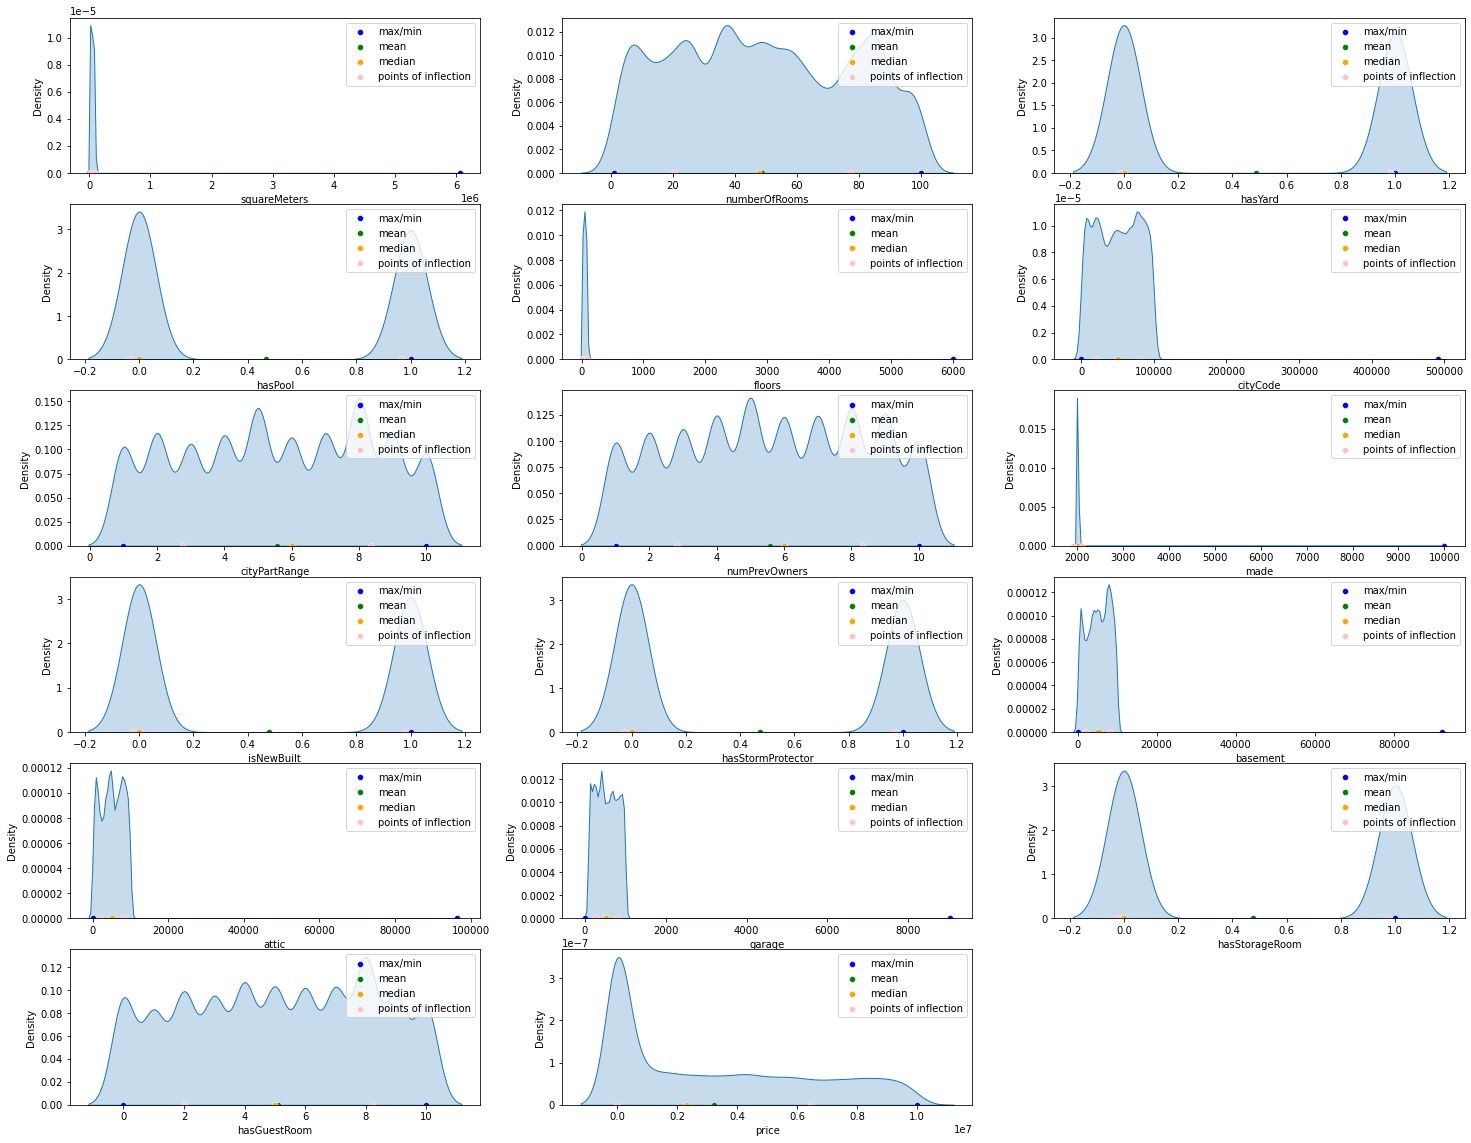

In [23]:
UVA_numeric(train,train.columns)

### Finding Outliers  

In [24]:
def UVA_outliers(data, var_group, include_outlier=True):

  '''
  Univariate Analysis of outliers
  Takes a group of variables (INTEGER and FLOAT) and plot/print boxplot and descriptives
  Runs a loop: calculate all the descriptives of i(th) varibales and ploot/print it
  data: DataFrame object from which to plot from
  var_group: list of subject columns
  include_outliers(bool): whether to include outliers or not, default = True 
  '''

  size = len(var_group)
  plt.figure(figsize=(7*size, 4), dpi=100)

  #looping for each variable
  for j,i in enumerate(var_group):

    # calculating descriptives of variables
    quant25 = data[i].quantile(0.25)
    quant75 = data[i].quantile(0.75)
    IQR = quant75 - quant25
    med = data[i].median()
    whis_low = quant25 - (1.5*IQR)
    whis_high = quant75 + (1.5*IQR)

    #calculating descriptives of variables
    outlier_high = len(data[i][data[i]>whis_high])
    outlier_low = len(data[i][data[i]<whis_low])

    if include_outlier:

      #plotting the variable with every information
      plt.subplot(1,size,j+1)
      sns.boxplot(data[i],orient="v")
      plt.ylabel(f'{i}')
      plt.title(f'With outliers\nIQR = {round(IQR,2)}; Median = {round(med,2)}; \n 2nd, 3rd Quartile={(round(quant25,2), round(quant75,2))},\nOutlier(low/high)={(outlier_low,outlier_high)}')

    else:

      #replacing outliers with max/min whisker
      data2 = data[var_group][:]
      data2[i][data2[i]>whis_high] = whis_high+1
      data2[i][data2[i]<whis_low] = whis_low-1

      #plotting without outliers
      plt.subplot(1,size,j+1)
      sns.boxplot(data2[i], orient="v")
      plt.ylabel(f'{i}')
      plt.title(f'Without outliers\nIQR = {round(IQR,2)}; Median = {round(med,2)}; \n 1st, 3rd Quartile={(round(quant25,2), round(quant75,2))},\nOutlier(low/high)={(outlier_low,outlier_high)}')


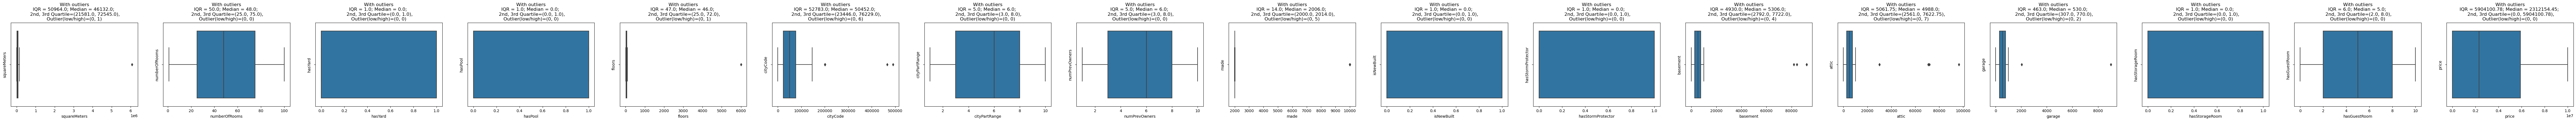

In [25]:
UVA_outliers(train,train.columns,True)

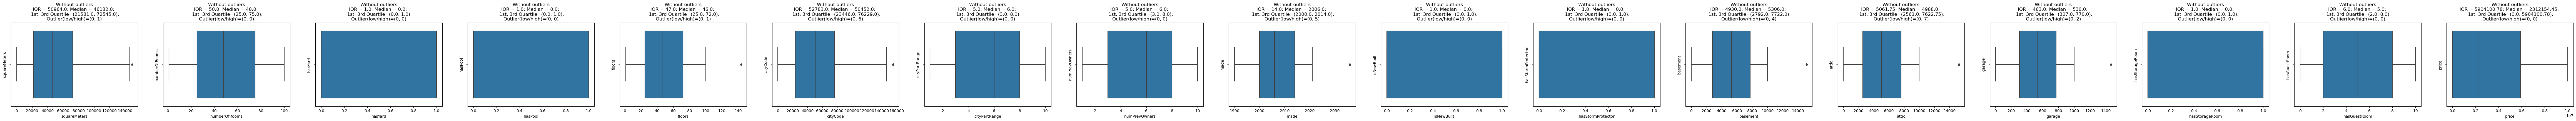

In [26]:
UVA_outliers(train,train.columns,False)

* Columns like squareMeters, floors, cityCode, made, basement, attic, garage have some outliers but number of outliers is very less

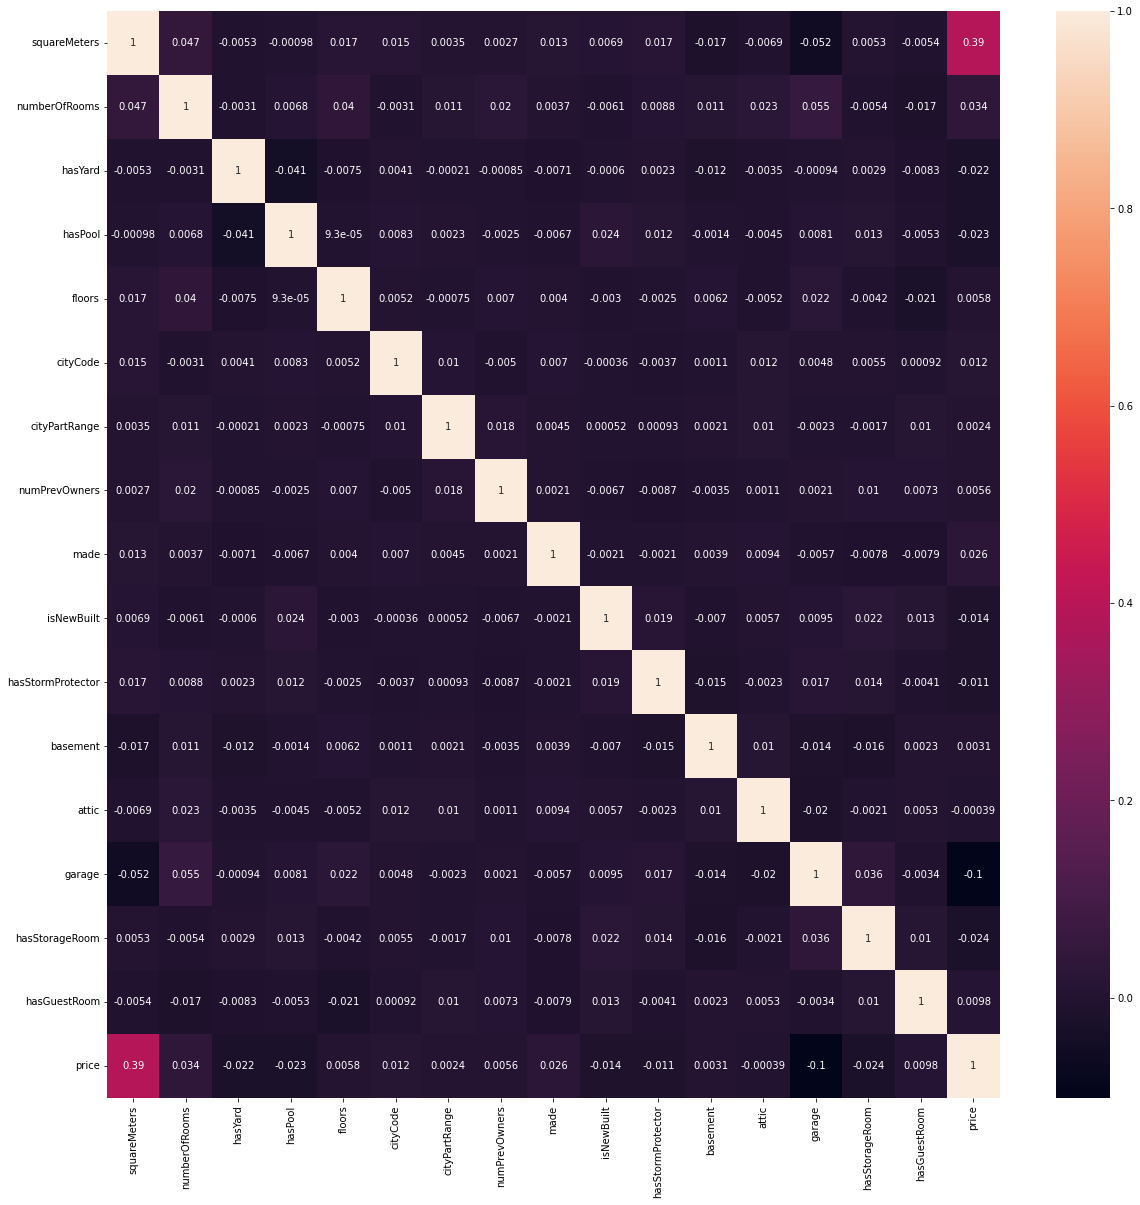

In [27]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(),annot=True)
plt.show()

* price and squareMeters has high corelation

# Handle Outliers

In [28]:
def handle_outliers(data,col):
    size=len(col)
    quant25 = data[col].quantile(0.25)
    quant75 = data[col].quantile(0.75)
    IQR = quant75 - quant25
    whis_low = quant25 - (1.5*IQR)
    whis_high = quant75 + (1.5*IQR)
    
    #replacing outliers with max/min whisker
    #data2 = data[var_group][:]
    data[col][data[col]>whis_high] = whis_high+1
    data[col][data[col]<whis_low] = whis_low-1

In [29]:
handle_outliers(train,'squareMeters')

In [30]:
handle_outliers(train,'floors')

In [31]:
handle_outliers(train,'cityCode')

In [32]:
handle_outliers(train,'made')

In [33]:
handle_outliers(train,'basement')

In [34]:
handle_outliers(train,'attic')

In [35]:
handle_outliers(train,'garage')

In [36]:
train.shape

(32730, 17)

# Modelling

In [37]:
test=test.drop('id',axis=1)

In [38]:
X = train.drop('price', axis=1)
y = train['price']
#SPLITS = 5
#RANDOM = 1
#ESTIMATORS = 1000
#clfs = []
#scores = []
#y_pred = []

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                              test_size = 0.3, 
                                              random_state = 1)

In [72]:
model1=XGBRegressor(max_depth=3, learning_rate=0.2 , n_estimators=1000, objective='reg:squarederror', booster='gbtree')
XGB=model1.fit(X_train,y_train)
xgb_prediction=XGB.predict(X_test)
pred1=XGB.predict(test)

In [62]:
model2=LGBMRegressor(max_depth=3, learning_rate=0.2 , n_estimators=1000)
lgbm=model2.fit(X_train,y_train)
lgbm_prediction=lgbm.predict(X_test)
pred2=lgbm.predict(test)

In [65]:
model3=CatBoostRegressor(max_depth=3, learning_rate=0.2 , n_estimators=1000)
cat=model3.fit(X_train,y_train)
cat_prediction=cat.predict(X_test)
pred3=cat.predict(test)

0:	learn: 3050118.9360042	total: 61.7ms	remaining: 1m 1s
1:	learn: 2905314.4931062	total: 64.9ms	remaining: 32.4s
2:	learn: 2799677.6885517	total: 67.8ms	remaining: 22.5s
3:	learn: 2720341.9183688	total: 70.4ms	remaining: 17.5s
4:	learn: 2670345.1013604	total: 73.5ms	remaining: 14.6s
5:	learn: 2628826.5245438	total: 76ms	remaining: 12.6s
6:	learn: 2602317.2793119	total: 78.6ms	remaining: 11.1s
7:	learn: 2582552.3695498	total: 81.3ms	remaining: 10.1s
8:	learn: 2565989.2445520	total: 83.8ms	remaining: 9.22s
9:	learn: 2553353.3820376	total: 86.1ms	remaining: 8.52s
10:	learn: 2543556.0417607	total: 88.4ms	remaining: 7.95s
11:	learn: 2537686.5655631	total: 90.7ms	remaining: 7.47s
12:	learn: 2531524.8034587	total: 92.9ms	remaining: 7.05s
13:	learn: 2527744.7622552	total: 95.2ms	remaining: 6.71s
14:	learn: 2524071.0983561	total: 97.4ms	remaining: 6.4s
15:	learn: 2521153.8468445	total: 99.7ms	remaining: 6.13s
16:	learn: 2503247.5968685	total: 102ms	remaining: 5.91s
17:	learn: 2499595.2704342	t

In [66]:
preds = np.array([pred1, pred2, pred3]).mean(axis=0)

In [67]:
len(preds)

15154

In [68]:
sub['price']=preds

In [69]:
sub.head()

,id,price
0,22730,3.244566e+06
1,22731,4.672096e+06
2,22732,6.051398e+06
3,22733,1.721557e+06
4,22734,5.637853e+06


In [70]:
sub.to_csv('submission.csv',index=False)